# Advanced Lane Finding

## 1. Import

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 2. Constants

In [3]:
image_shape = (1280, 720)
ploty = np.linspace(0, image_shape[1] - 1, image_shape[0])

## 3. Helper Functions

In [6]:
def test_image(name):
    test_image_path = './test_images/%s' % name
    return mpimg.imread(test_image_path, cv2.IMREAD_COLOR)

def show_image(image):
    plt.imshow(image)
    
def show_image_gray(image):
    plt.imshow(image, cmap='gray')

## 4. Camera Calibration

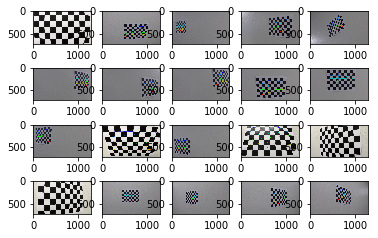

In [7]:
nx = 9
ny = 6

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
object_points = np.zeros((ny * nx, 3), np.float32)
object_points[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
object_points_list = [] # 3d points in real world space
image_points_list = [] # 2d points in image plane.

# Find all calibration images
image_names = glob.glob('./camera_cal/calibration*.jpg')

# Parameters for display
figure =plt.figure()
num_images = len(image_names)
num_row = int(np.floor(np.sqrt(num_images)))
num_col = int(np.ceil(num_images / num_row))

for image_index in range(num_images):
    # Read image.
    image_name = image_names[image_index]
    image = mpimg.imread(image_name)
    
    # Since the shapes of the images are not all the same, crop the images for precision
    image = image[0:image_shape[1], 0:image_shape[0]]
    
    # Transform image to grayscale.
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners.
    ret, corners = cv2.findChessboardCorners(gray_image, (9,6), None)
    
    if ret:
        # Append object points and image points.
        object_points_list.append(object_points)
        image_points_list.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)

    # Draw image
    figure.add_subplot(num_row, num_col, image_index + 1)
    plt.imshow(image)
    
# Calculate calibration.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points_list, image_points_list, image_shape, None, None)

## 5. Image Undistortion

In [8]:
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

## 6. Test Image Undistortion

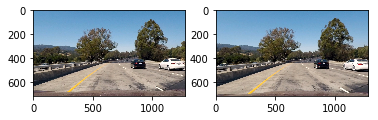

In [13]:
test1 = test_image('test1.jpg')
test1_undistorted = undistort(test1)

figure = plt.figure()
figure.add_subplot(1, 2, 1)
plt.imshow(test1)
figure.add_subplot(1, 2, 2)
plt.imshow(test1_undistorted)

plt.imsave('test1_undistorted.jpg', test1_undistorted)

## 7. HLS Color Space

In [14]:
def image_to_s_channel(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]

## 8. Test Color Space

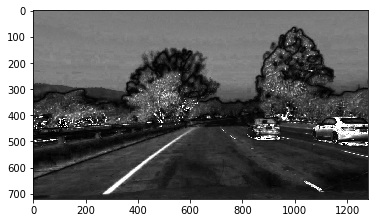

In [17]:
test1_s_channel = image_to_s_channel(undistort(test_image('test1.jpg')))
show_image_gray(test1_s_channel)
plt.imsave('test1_s_channel.jpg', test1_s_channel)

## 9. Thresholding Lane Lines

In [20]:
def binary_output(matrix, threshold):
    binary = np.zeros_like(matrix)
    binary[(matrix >= threshold[0]) & (matrix < threshold[1])] = 1
    return binary


def scale(matrix):
    return matrix / np.max(matrix) * 255


class Thresholding():
    def __init__(self,
                 sobel_kernel=3,
                 threshold_magnitude_min=0, threshold_magnitude_max=255,
                 threshold_direction_min=0, threshold_direction_max=np.pi / 2,
                 threshold_color_min=0, threshold_color_max=255):
        self.sobel_kernel = sobel_kernel
        self.threshold_magnitude_min = threshold_magnitude_min
        self.threshold_magnitude_max = threshold_magnitude_max
        self.threshold_direction_min = threshold_direction_min
        self.threshold_direction_max = threshold_direction_max
        self.threshold_color_min = threshold_color_min
        self.threshold_color_max = threshold_color_max
    
    def threshold(self, gray_image):
        combined_threshold = np.zeros_like(gray_image)
        mag_binary = self.magnitude_threshold(gray_image,
                                              threshold=(self.threshold_magnitude_min,
                                                         self.threshold_magnitude_max))
        dir_binary = self.direction_threshold(gray_image,
                                              threshold=(self.threshold_direction_min,
                                                         self.threshold_direction_max))
        color_binary = self.color_threshold(gray_image,
                                            threshold=(self.threshold_color_min,
                                                       self.threshold_color_max))
        
        combined_threshold[
            (((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1))
        ] = 1
        return combined_threshold
    
    def sobelx(self, gray_image):
        return cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)

    def sobely(self, gray_image):
        return cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)

    def magnitude_threshold(self, gray_image, threshold):
        sobel_magnitude = np.sqrt(
            self.sobelx(gray_image) ** 2 + self.sobely(gray_image) ** 2)
        return binary_output(scale(sobel_magnitude), threshold)

    def direction_threshold(self, gray_image, threshold):
        sobel_direction = np.arctan2(
            np.absolute(self.sobely(gray_image)),
            np.absolute(self.sobelx(gray_image)))
        return binary_output(sobel_direction, threshold)
    
    def color_threshold(self, gray_image, threshold):
        return binary_output(gray_image, threshold)


def threshold(image):
    return Thresholding(sobel_kernel=5,
                        threshold_magnitude_min=50, threshold_magnitude_max=199,
                        threshold_direction_min=0.7, threshold_direction_max=1.4,
                        threshold_color_min=160, threshold_color_max=255
                       ).threshold(image)

## 10. Test Thresholding

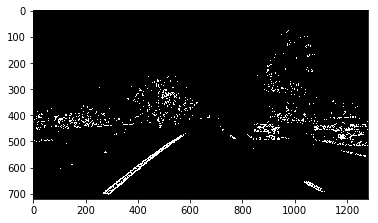

In [21]:
test1_thresholded = threshold(test1_s_channel)
show_image_gray(test1_thresholded)
plt.imsave('test1_thresholded.jpg', test1_thresholded)

## 11. Perspective Transform

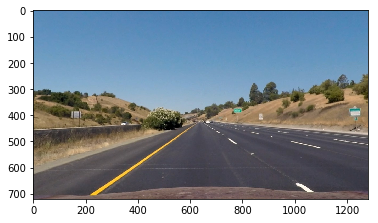

In [23]:
# Undistorted image with straight lines
straight_line_image = mpimg.imread('./test_images/straight_lines1.jpg')
straight_line_image_undistorted = undistort(straight_line_image)
plt.imshow(straight_line_image_undistorted)
plt.imsave('./test_images/straight_lines1_undistorted.jpg', undistort(straight_line_image))

In [24]:
# Picked points manually
source_points = np.float32((
    (228, 704),  # bottom left
    (1059, 692), # bottom right
    (531, 496),  # top left
    (755, 496),  # top right
))

destination_points = np.float32((
    (228, 704),
    (1059, 692),
    (228, 300),
    (1059, 300),
))

transform_matrix = cv2.getPerspectiveTransform(source_points, destination_points)
inverse_transform_matrix = cv2.getPerspectiveTransform(destination_points, source_points)

def warp(gray_image):
    return cv2.warpPerspective(gray_image, transform_matrix, (1280, 720), flags=cv2.INTER_LINEAR)

def unwarp(gray_image):
    return cv2.warpPerspective(gray_image, inverse_transform_matrix, (1280, 720), flags=cv2.INTER_LINEAR)

## 12. Test Perspective Transform

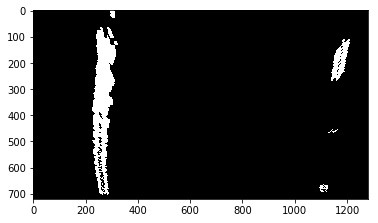

In [26]:
test1_warped = warp(test1_thresholded)
show_image_gray(test1_warped)
plt.imsave('test1_warped.jpg', test1_warped)

## 13. Find Lane Lines
### 13.1 Peaks in a Histogram

In [ ]:
histogram = np.sum(binary_warped[image_shape[1]//2:,:], axis=0)
plt.plot(histogram)

### 13.2 Line Class and Lanes Class

In [27]:
MAX_NUM_RECENT_VALID_FIT = 5

def x_from_fit(fit, y):
    return fit[0] * y ** 2 + fit[1] * y + fit[2]

def x_in_range(left_fit, right_fit, y, distance_min, distance_max):
    distance = x_from_fit(right_fit, y) - x_from_fit(left_fit, y)
    return distance >= distance_min and distance <= distance_max

def get_curvature(fit):
    x = all_x_from_fit(fit)
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty * ym_per_pix, x * xm_per_pix, 2)

    # Calculate the new radii of curvature
    return ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])

def all_x_from_fit(fit):
    return x_from_fit(fit, ploty)

# Representing one lane line.
class Line:
    def __init__(self):
        self.recent_valid_fit = []
        self.curvature = None
    
    def add_fit(self, fit):
        self.recent_valid_fit.append(fit)
        self.curvature = get_curvature(fit)
        if len(self.recent_valid_fit) > MAX_NUM_RECENT_VALID_FIT:
            del self.recent_valid_fit[0]
    
    def has_valid_fit(self):
        return len(self.recent_valid_fit) > 0
    
    def get_fit(self):
        return self.recent_valid_fit[-1]
    
    def get_fitx(self, y):
        return x_from_fit(self.get_fit(), y)
    
    def get_fitx_all(self):
        return all_x_from_fit(self.get_fit())
    
    def get_curvature(self):
        return get_curvature(self.get_fit())

    def copy(self):
        line = Line()
        line.recent_valid_fit = self.recent_valid_fit[:]
        return line

# Representing two lane lines, and encapsulating some searching logic.
class Lanes:
    def __init__(self):
        self.num_consecutive_failures = 0
        self.left = Line()
        self.right = Line()
    
    def has_valid_fit(self):
        return self.left.has_valid_fit() and self.right.has_valid_fit()
    
    def add_fit(self, left_fit, right_fit):
        if not self.left.has_valid_fit() or not self.right.has_valid_fit() or self.sanity_check(left_fit, right_fit):
            self.left.add_fit(left_fit)
            self.right.add_fit(right_fit)
            self.num_consecutive_failures = 0
        else:
            self.num_consecutive_failures += 1
    
    def from_scratch(self):
        return self.num_consecutive_failures > 5
    
    def sanity_check(self, left_fit, right_fit):
        return x_in_range(left_fit, right_fit, np.max(ploty), 600, 1000) and \
            x_in_range(left_fit, right_fit, 0, 500, 1100) and \
            np.absolute(get_curvature(left_fit) - get_curvature(right_fit)) <= 800
    
    def copy(self):
        lanes = Lanes()
        lanes.left = self.left.copy()
        lanes.right = self.right.copy()
        return lanes
    
    def get_curvature(self):
        if self.left.curvature is None or self.right.curvature is None:
            return None
        return (self.left.curvature + self.right.curvature) / 2

    def get_position(self):
        left = self.left.get_fitx(np.max(ploty))
        right = self.right.get_fitx(np.max(ploty))
        middle = (left + right) / 2
        vehicle = image_shape[0] / 2
        scale = (right - left) / 3.7 # pixel / m
        return (vehicle - middle) / scale

### 13.3 Sliding Window

In [46]:
# Following code is modified from Udacity class material

def fit(x, y):
    return np.polyfit(y, x, 2)


def curvature(x, y):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty * ym_per_pix, x * xm_per_pix, 2)

    # Calculate the new radii of curvature
    return ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])


def sliding_window_search(image, lanes=Lanes(), output=False):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    if not lanes.has_valid_fit() or lanes.from_scratch():
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((image, image, image))*255

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(image.shape[0]/nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        margin = 100
        left_lane_inds = ((nonzerox > (lanes.left.get_fitx(nonzeroy) - margin)) & 
                          (nonzerox < (lanes.left.get_fitx(nonzeroy) + margin)))
        right_lane_inds = ((nonzerox > (lanes.right.get_fitx(nonzeroy) - margin)) &
                           (nonzerox < (lanes.right.get_fitx(nonzeroy) + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if len(lefty) > 0 and len(leftx) > 0 and len(righty) > 0 and len(rightx) > 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        lanes.add_fit(left_fit, right_fit)
    
    if output:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((image, image, image))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_fitx = lanes.left.get_fitx_all()
        right_fitx = lanes.right.get_fitx_all()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        return lanes, result
    else:
        return lanes

### 13.4 Test Sliding Window on New Image

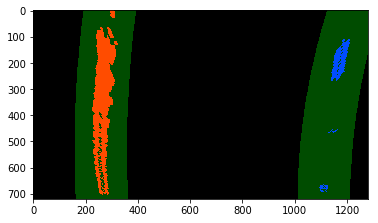

In [48]:
lanes, test1_sliding_window = sliding_window_search(test1_warped, Lanes(), True)
plt.imshow(test1_sliding_window)
plt.imsave('test1_sliding_window.jpg', test1_sliding_window)

### 13.5 Test When Lines on Previous Frame are Known

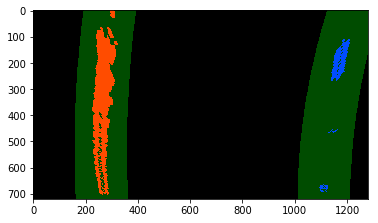

In [53]:
lanes, test1_sliding_window_again = sliding_window_search(test1_warped, lanes, True)
plt.imshow(test1_sliding_window_again)

## Pipeline

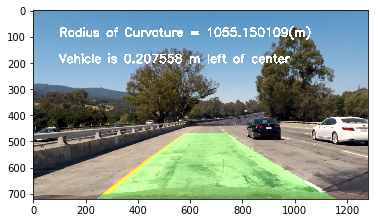

In [56]:
def pipeline(image, lanes=Lanes()):
    image_undistorted = undistort(image)
    image_s_channel = image_to_s_channel(image_undistorted)
    image_thresholded = threshold(image_s_channel)
    image_warped = warp(image_thresholded)
    lanes = sliding_window_search(image_warped, lanes)

    left_fitx = lanes.left.get_fitx_all()
    right_fitx = lanes.right.get_fitx_all()
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_transform_matrix, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image_undistorted, 1, newwarp, 0.3, 0)
    
    # Add curvature and position
    cv2.putText(result, 'Radius of Curvature = %f(m)' % lanes.get_curvature(), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255], 5)
    cv2.putText(result, 'Vehicle is %f m %s of center' % (np.absolute(lanes.get_position()), 'right' if lanes.get_position() >= 0 else 'left'), (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, [255, 255, 255], 5)
    return result, lanes

test1_pipeline, lanes = pipeline(test1)
plt.imshow(test1_pipeline)
plt.imsave('test1_pipeline.jpg', test1_pipeline)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def image_processor_generator():
    lanes = Lanes()
    results = []
    def process_image(image):
        nonlocal lanes, results
        result, lanes = pipeline(image, lanes)
        results.append((image, result, lanes.copy()))
        return result
    def get_results():
        return results
    return process_image, get_results

video_output_name = 'project_video_output.mp4'
video_input = VideoFileClip("project_video.mp4")
process_image, get_results = image_processor_generator()
video_output = video_input.fl_image(process_image)
%time video_output.write_videofile(video_output_name, audio=False)